## Аналитическая записка. 

## 1) 
Человекопоток в окрестности является основным показателем, определяющим экономическую эффективность отделения.
Параметр distance_500 показывает стабильно высокую корреляцию с:
    
* price - цена квадратного метра покупки жилья в районе Москвы/по городу вне Москвы, 

* finance_count - количество финансовых учреждений в ближайшей окрестности,

* cafe_count - количество кафе в ближайшей окрестности, 

* job_gov_count - количество мест работы и государственных учреждений в ближайшей окрестности, 

* metro_count - количество станций метро в ближайшей окрестности, 

* transport_count - количество остановок в ближайшей окрестности

На основании чего можно выделить три основным кластера:
    
**1 кластер.** Цена квадратного метра покупки жилья в районе Москвы/по городу вне Москвы - price

**2 кластер.** Инфраструктура - finance_count, cafe_count, job_gov_count

**3 кластер.** Транспорт - metro_count, transport_count


## 2)
Запуская Random Forest (на выборке, кластеризованной по DBSCAN), определям признаки, оказывающие наибольшее влияние.
Оказалось, что самым важными является ОПС Б1_2, ОПС Б1, is_moscow. Примерно одинаковый вклад вносят place_type ТП и price.

## Рекомендации

**1.** Экономическая эффективность отделений зависит в первую очередь от человекопотока, поэтому открывать отеления нужно в районах
с развитой инфраструктурой и хорошим транспортным сообщением.

**2.** Важной характеристикой оказалась цена на недвижимость - имеет смысл открывать почтовые отделения типа ОПС Б1, ОПС Б1_2, КЦ 
в более дорогих районах и банкоматы или отделения с минимальным количеством работников в отдалённой местности.


In [ ]:
# !pip install pandas-profiling
# !pip install umap-learn

In [292]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import decomposition

from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.cluster import DBSCAN

import umap

import warnings
warnings.filterwarnings("ignore")

## 1. Пре-процессинг данных

In [293]:
df = pd.read_csv('data.csv')
df.shape

(717, 33)

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      717 non-null    int64  
 1   post_id                 545 non-null    float64
 2   open_date               676 non-null    float64
 3   street                  717 non-null    object 
 4   address                 717 non-null    object 
 5   place_type              717 non-null    object 
 6   shop_centre             717 non-null    bool   
 7   dns                     717 non-null    bool   
 8   lat                     717 non-null    float64
 9   lon                     717 non-null    float64
 10  response                717 non-null    object 
 11  district                717 non-null    object 
 12  post2                   717 non-null    object 
 13  is_center               717 non-null    bool   
 14  price                   612 non-null    fl

In [295]:
df.head()

,id,post_id,open_date,street,address,place_type,shop_centre,dns,lat,lon,...,job_gov_count,metro_count,metro_min_distance,transport_count,transport_min_distance,working_days,work_hours,weekday_availability,office_hours,is_moscow
0,18017,NaN,2017.0,пл. Преображенская,"пл. Преображенская, дом 8",other,False,False,51.279520,37.502010,...,9,1,210.602515,19,90.504883,6.0,11.0,1.0,NaN,True
1,5546,NaN,2015.0,пл. Преображенская,"пл. Преображенская, д. 8",ТП,False,False,51.279520,37.502010,...,9,1,210.602515,19,90.504883,6.0,11.0,1.0,NaN,True
2,6211,NaN,2015.0,пл. Преображенская,"пл. Преображенская, д. 8 ТП №2",ТП,False,False,51.279520,37.502010,...,15,1,434.931238,23,25.471714,6.0,11.0,1.0,NaN,True
3,18067,NaN,2017.0,пл. Преображенская,"пл. Преображенская, дом 8",other,False,False,51.279520,37.502010,...,9,1,210.602515,19,90.504883,6.0,11.0,1.0,NaN,True
4,12748,141551.0,2017.0,рп Андреевка,"рп Андреевка, дом 3 Б",ОПС Б1,False,False,52.191502,30.293079,...,2,0,NaN,7,164.255410,6.0,11.0,1.0,NaN,False


In [296]:
prof = ProfileReport(df, minimal=True)
prof.to_file(output_file='output.html')
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**1.** Не будем использовать в анализе:

* категориальные признаки, которые имеют высокую кардинальность

* признаки, у которыx более 10% пропусков (кроме price - о нем в п. 4.)

**2.** Для категориальных признаков, имеющих небольшое количество значений, произведем one-hot encodong.

**3.** Для признака metro_min_distance нулевые значения заменим большим значением, 
так как если значение отсутвует, то, значит, отделение в городе, где нет метро, и 
введем переменную, наличие метро.

Аналогично для transport_min_distance.


**4.** В Pandas Profiling Report заметим, что:

* количество пропущенных значений в price: 105

* количество значений в place_type для 'ТП': 105
    
Посмотрим на типы: ['other', 'ТП', 'ОПС Б1', 'ОПС Б1_2', 'КЦ']
    
С официальной странички Почта-Банк в ВК https://vk.com/wall-47158016_52591:
        
**(1)** Самые массовые форматы - с банковскими сотрудниками или почтовыми агентами - мы развиваем на базе почтовых отделений.
Скорее всего, это 'ОПС Б1', 'ОПС Б1_2', 'КЦ'.

https://pochta-bank-lk.ru/pochta-bank-slovar-bankovskih-terminov/
    
https://ppt-online.org/643167
    

**(2)** Самый скромный с точки зрения количества отделений формат работы банка - флагманские клиентские центры.
Внешне они мало чем отличаются от обычных банковских офисов, и чаще размещаются на оживленных улицах городов.
Скорее всего, это 'other'. 

**(3)** Иногда эти отделения выглядят как небольшие избушки. В них мы устанавливаем pos-терминалы.
Поэтому, если вы приехали к бабушке в деревню ...
Скорее всего, это 'ТП'. 

Помним, что 'ТП' и мы их отнесли к малонаселённым объектам, и пропущенных цен тоже 105. Возможно, нет данных об этой местности. 
Поэтому заменим соответствующий пропуск нулём.

In [298]:
df['price'].isnull().sum()
df['price'] = df['price'].fillna(0)
df['price'].isnull().sum()

0

In [299]:
df['open_date']= pd.to_datetime(df['open_date'], format='%Y')
df['open_date'] = df['open_date'] - df['open_date'].min()
df['open_date'] = df['open_date'] / np.timedelta64(1, 'Y')
# df['open_date'].head()

In [300]:
cat_features = ['open_date', 'place_type']
bool_features = ['shop_centre', 'dns', 'is_center', 'is_moscow']
num_features = ['price', 'parking_count', 'parking_min_distance', 
                'finance_count', 'shop_count', 'distance_100', 
                'distance_500', 'cafe_count', 'culture_count', 'job_gov_count', 'metro_count', 
                'metro_min_distance', 'transport_count', 'transport_min_distance', 'working_days', 'work_hours',
                'weekday_availability']

In [301]:
# сделаем новые признаки
df['is_metro'] = df['metro_min_distance'].apply(lambda x: 1 if x == x else 0)
df['is_transport'] = df['transport_min_distance'].apply(lambda x: 1 if x == x else 0)

bool_features = bool_features + ['is_metro', 'is_transport']

max_value = df['metro_min_distance'].mean()
df['metro_min_distance'] = df['metro_min_distance'].apply(lambda x: x if x == x else max_value ** 2)

max_value = df['transport_min_distance'].max()
df['transport_min_distance'] = df['transport_min_distance'].apply(lambda x: x if x == x else max_value ** 2)

In [302]:
# заменим пропуски
for feat in cat_features:
    df[feat] = df[feat].fillna( df[feat].mode()[0])
    
for feat in num_features:
    df[feat] = df[feat].fillna( df[feat].median())

In [303]:
X = pd.concat([df[num_features],df[bool_features], pd.get_dummies(df[cat_features])], axis = 1)
X.head()

,price,parking_count,parking_min_distance,finance_count,shop_count,distance_100,distance_500,cafe_count,culture_count,job_gov_count,...,is_center,is_moscow,is_metro,is_transport,open_date,place_type_other,place_type_КЦ,place_type_ОПС Б1,place_type_ОПС Б1_2,place_type_ТП
0,227892.0,51,22.437756,7,16,7.648714,139.203857,10,2,9,...,False,True,1,1,5.002156,1,0,0,0,0
1,227892.0,51,22.437756,7,16,7.648714,139.203857,10,2,9,...,False,True,1,1,3.000746,0,0,0,0,1
2,227892.0,39,39.888740,8,15,11.275286,111.105429,12,2,15,...,False,True,1,1,3.000746,0,0,0,0,1
3,227892.0,51,22.437756,7,16,7.648714,139.203857,10,2,9,...,False,True,1,1,5.002156,1,0,0,0,0
4,0.0,21,74.395163,3,15,2.988571,23.848429,5,1,2,...,False,False,0,1,5.002156,0,0,1,0,0


In [304]:
# отнормируем значения
scaler = StandardScaler()

names = X.columns

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled)
X.columns = names
X.head()

,price,parking_count,parking_min_distance,finance_count,shop_count,distance_100,distance_500,cafe_count,culture_count,job_gov_count,...,is_center,is_moscow,is_metro,is_transport,open_date,place_type_other,place_type_КЦ,place_type_ОПС Б1,place_type_ОПС Б1_2,place_type_ТП
0,0.647202,0.500000,0.013952,0.304348,0.410256,0.678361,0.745752,0.208333,0.024096,0.257143,...,0.0,1.0,1.0,1.0,0.714509,1.0,0.0,0.0,0.0,0.0
1,0.647202,0.500000,0.013952,0.304348,0.410256,0.678361,0.745752,0.208333,0.024096,0.257143,...,0.0,1.0,1.0,1.0,0.428627,0.0,0.0,0.0,0.0,1.0
2,0.647202,0.382353,0.042408,0.347826,0.384615,1.000000,0.595160,0.250000,0.024096,0.428571,...,0.0,1.0,1.0,1.0,0.428627,0.0,0.0,0.0,0.0,1.0
3,0.647202,0.500000,0.013952,0.304348,0.410256,0.678361,0.745752,0.208333,0.024096,0.257143,...,0.0,1.0,1.0,1.0,0.714509,1.0,0.0,0.0,0.0,0.0
4,0.000000,0.205882,0.098675,0.130435,0.384615,0.265055,0.127511,0.104167,0.012048,0.057143,...,0.0,0.0,0.0,1.0,0.714509,0.0,0.0,1.0,0.0,0.0


In [305]:
X.dtypes

price                     float64
parking_count             float64
parking_min_distance      float64
finance_count             float64
shop_count                float64
distance_100              float64
distance_500              float64
cafe_count                float64
culture_count             float64
job_gov_count             float64
metro_count               float64
metro_min_distance        float64
transport_count           float64
transport_min_distance    float64
working_days              float64
work_hours                float64
weekday_availability      float64
shop_centre               float64
dns                       float64
is_center                 float64
is_moscow                 float64
is_metro                  float64
is_transport              float64
open_date                 float64
place_type_other          float64
place_type_КЦ             float64
place_type_ОПС Б1         float64
place_type_ОПС Б1_2       float64
place_type_ТП             float64
dtype: object

## 2. Кластеризация отделений

In [306]:
# ради интереса построим дендограмму 
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

In [307]:
distance_mat = pdist(X) # pdist считает верхний треугольник матрицы попарных расстояний
print(distance_mat )

[1.44281962 1.50837968 0.         ... 2.12841927 2.27065325 1.53337396]


In [308]:
Z = hierarchy.linkage(distance_mat, 'single')

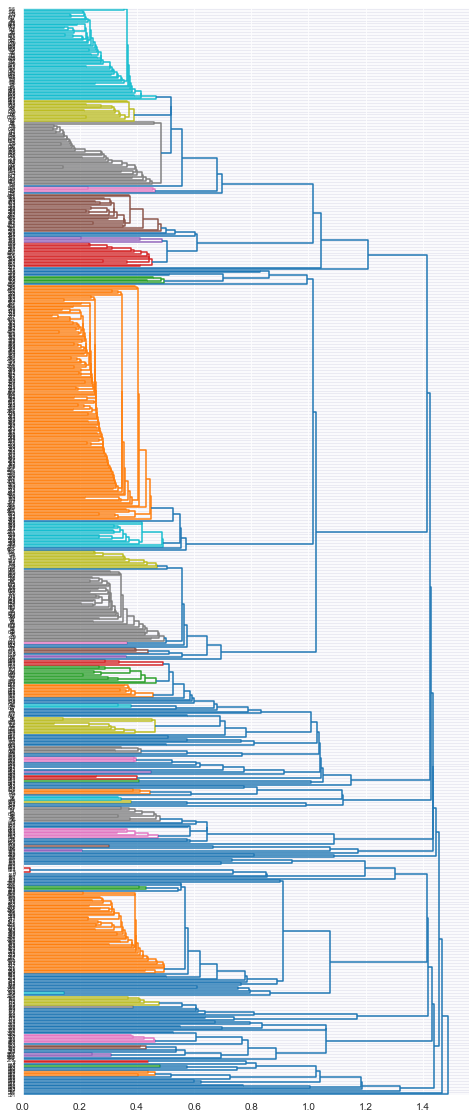

In [309]:
# не очень показательная картинка
plt.figure(figsize=(8, 20))
dn = hierarchy.dendrogram(Z, color_threshold=0.5, orientation='right')

In [133]:
X.corr().head() 
# for i in X.columns:
#     print(X.corr()[i].nlargest(3))
#     print()

,price,parking_count,parking_min_distance,finance_count,shop_count,distance_100,distance_500,cafe_count,culture_count,job_gov_count,...,is_center,is_moscow,is_metro,is_transport,open_date,place_type_other,place_type_КЦ,place_type_ОПС Б1,place_type_ОПС Б1_2,place_type_ТП
price,1.000000,0.130171,0.018488,0.318578,0.099449,0.401815,0.629930,0.332534,0.144947,0.249393,...,0.340952,0.857918,0.451797,0.040735,0.081948,0.044363,-0.039956,-0.273882,0.332536,-0.117883
parking_count,0.130171,1.000000,-0.437708,0.056035,0.415596,0.118792,0.172670,0.079296,-0.087962,0.101620,...,-0.058619,0.188204,0.066659,0.009799,-0.078588,-0.001006,0.102120,-0.074567,0.053710,-0.047027
parking_min_distance,0.018488,-0.437708,1.000000,0.008391,-0.171652,-0.027172,-0.064002,0.073122,0.128122,0.013920,...,0.122072,-0.019651,0.043855,0.031648,0.097603,-0.021742,-0.030063,0.073529,-0.011270,-0.046205
finance_count,0.318578,0.056035,0.008391,1.000000,0.221616,0.333691,0.496841,0.636769,0.322077,0.600637,...,0.419132,0.175558,0.446620,-0.011949,-0.074582,0.093427,0.210520,-0.120493,-0.078046,0.073853
shop_count,0.099449,0.415596,-0.171652,0.221616,1.000000,0.153304,0.180883,0.249435,0.001321,0.231900,...,0.038043,0.032655,0.116048,0.103053,-0.051100,-0.031802,0.139603,-0.062764,0.008660,-0.005972


Высокую корреляцию показывают:
    
price с is_moscow и distance_500

finance_count, cafe_count, job_gov_count

metro_count, transport_count


is_moscow и price, но вводить кластер is_moscow не очень удачно (bool), 
инормативнее price (не в Москве дешевле).

Если рассуждать про кластеризацию отделений, то:

**1 кластер.** Цена квадратного метра покупки жилья в районе Москвы/по городу вне Москвы - price

**2 кластер.** Инфраструктура - finance_count, cafe_count, job_gov_count

**3 кластер.** Транспорт - metro_count, transport_count

DBSCAN показывает более детальную кластеризацию.

In [310]:
cl = pd.DataFrame()
cl['Price'] = X['price']
cl['Infrastructure'] = X['finance_count'] + X['cafe_count'] + X['job_gov_count'] 
cl['Transport'] = X['metro_count'] + X['transport_count']
cl.head()

,Price,Infrastructure,Transport
0,0.647202,0.769824,0.988506
1,0.647202,0.769824,0.988506
2,0.647202,1.026398,1.126437
3,0.647202,0.769824,0.988506
4,0.000000,0.291744,0.241379


<AxesSubplot:>

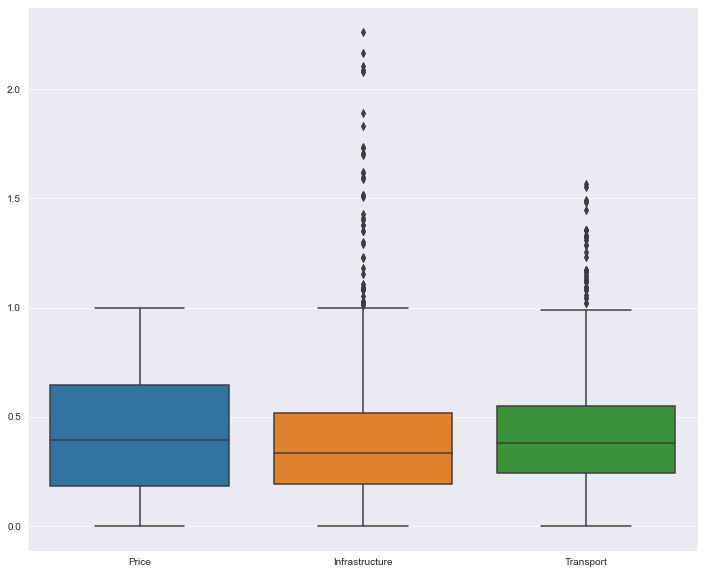

In [311]:
plt.figure(figsize=(12,10))
sns.boxplot(data = cl[['Price','Infrastructure','Transport']])

In [280]:
print(np.where(cl['Infrastructure'] > 1.0))

(array([  2,   7, 150, 154, 155, 156, 159, 170, 171, 196, 204, 205, 208,
       210, 234, 239, 258, 265, 269, 273, 274, 289, 301, 305, 312, 319,
       322, 336, 345, 357, 378, 379, 382, 406, 410, 413, 428, 429, 434,
       444, 448, 451, 539, 540, 588, 589], dtype=int64),)


In [281]:
print(np.where(cl['Transport']>1.0))

(array([  0,   1,   2,   3, 149, 150, 151, 154, 155, 156, 157, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       175, 176, 177, 190, 195, 196, 203, 204, 205, 208, 209, 210, 212,
       215, 225, 228, 229, 231, 233, 234, 235, 239, 240, 241, 242, 244,
       247, 248, 249, 258, 259, 260, 265, 273, 274, 275, 278, 282, 286,
       295, 300, 301, 303, 307, 310, 311, 312, 315, 316, 335, 336, 346,
       357, 358, 359, 360, 372, 378, 379, 381, 382, 385, 387, 388, 389,
       393, 394, 395, 400, 403, 407, 413, 414, 421, 423, 426, 428, 430,
       431, 434, 437, 438, 443, 444, 448, 449, 450, 451, 458, 471, 473,
       481, 486, 488, 489, 490, 491, 494, 496, 497, 499, 502, 503, 511,
       515, 520, 521, 522, 523, 525, 526, 527, 528, 532, 533, 535, 537,
       538, 539, 546, 550, 551, 552, 553, 555, 557, 559, 560], dtype=int64),)


In [328]:
# Выделить типичные и аномальные точки
# https://translated.turbopages.org/proxy_u/en-ru.ru.835af50c-63d788a9-12006218-74722d776562/https/www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
Q1 = cl['Price'].quantile(0.05)
Q3 = cl['Price'].quantile(0.95)
IQR = Q3 - Q1
cl = cl[(cl['Price'] >= Q1 - 1.5*IQR) & (cl['Price'] <= Q3 + 1.5*IQR)]

Q1 = cl['Infrastructure'].quantile(0.05)
Q3 = cl['Infrastructure'].quantile(0.95)
IQR = Q3 - Q1
cl = cl[(cl['Infrastructure'] >= Q1 - 1.5*IQR) & (cl['Infrastructure'] <= Q3 + 1.5*IQR)]

Q1 = cl['Transport'].quantile(0.05)
Q3 = cl['Transport'].quantile(0.95)
IQR = Q3 - Q1
cl = cl[(cl['Transport'] >= Q1 - 1.5*IQR) & (cl['Transport'] <= Q3 + 1.5*IQR)]

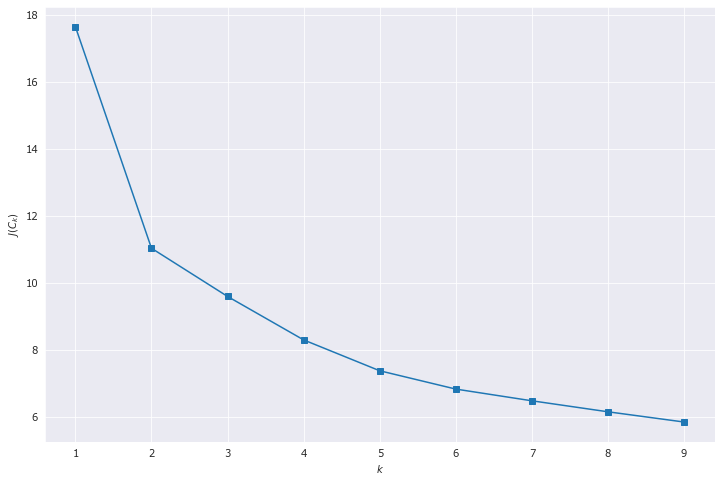

In [283]:
# вычисление JC
from sklearn.cluster import KMeans

inertia = []
n = 10
for k in range(1, n):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state=1).fit(cl)
    inertia.append(np.sqrt(kmeans.inertia_))

    
plt.figure(figsize=(12, 8))
plt.plot(range(1, n), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [312]:
# Попробуем DBSCAN на сl
# DBSCAN понимает где какая плотность точек. Попробуем запустить его на наших данных. Подумаем о том, какие параметры выбрать.
# 1 градус это примерно 5-10 км в средних широтах
# Параметр eps отвечает за максимальную дистанцию между двумя точками в рамках одного кластера. 

clustering = DBSCAN(eps=0.01, min_samples=4).fit(cl)
Y = clustering.labels_
len(set(Y))

3

In [313]:
# Попробуем DBSCAN на X

clustering = DBSCAN(eps=1.4, min_samples=2).fit(X)
Y = clustering.labels_
len(set(Y))

13

DBSCAN определил 13 кластеров.

## Посмотрим (TSNE, PCA, UMAP), как точки объединяются в кластеры:
    
**(1)** DBSCAN (c 1-го по 3-й графики)

**(2)** KNN (с 4-го по 6-й графики)

Wall time: 1.74 s


Text(0.5, 1.0, 't-SNE projection')

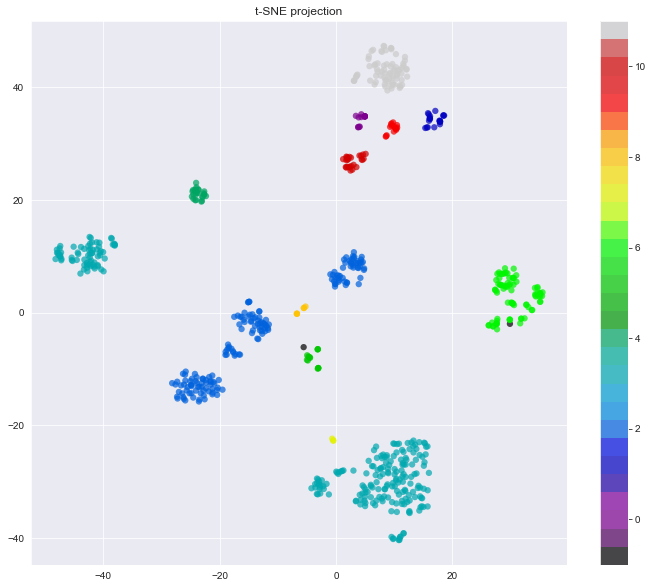

In [314]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 30))
plt.colorbar()
plt.title('t-SNE projection')

Projecting 29-dimensional data to 2D


Text(0.5, 1.0, 'PCA projection')

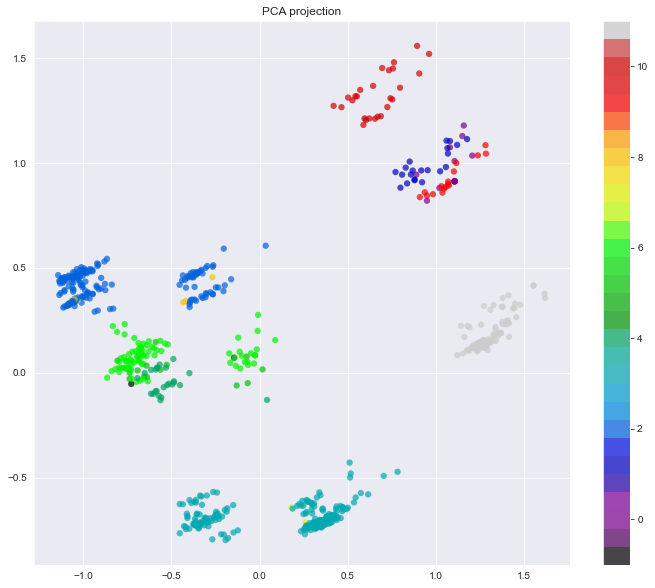

In [315]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 30))
plt.colorbar()
plt.title('PCA projection')

Text(0.5, 1.0, 'UMAP')

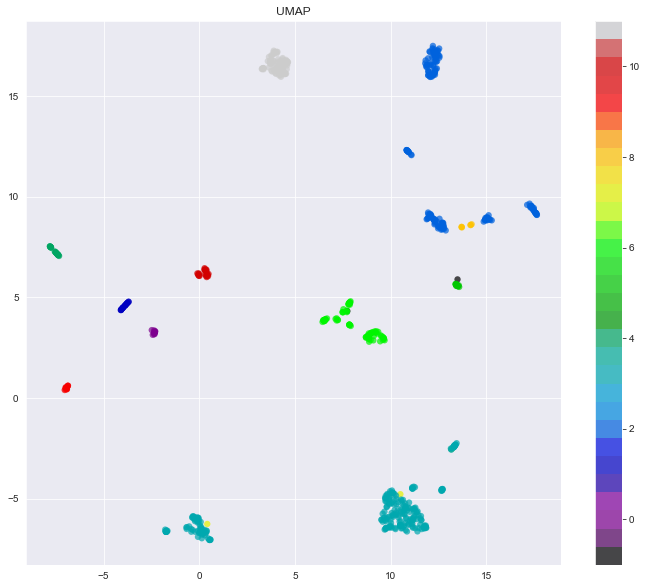

In [316]:
embedding = umap.UMAP().fit_transform(X)

plt.figure(figsize=(12,10))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 30))
plt.colorbar()
plt.title('UMAP')

In [317]:
pd.DataFrame(Y, columns = ['Y']).groupby('Y').size()

Y
-1       2
 0      14
 1      21
 2     173
 3     257
 4      25
 5      14
 6      83
 7       3
 8       6
 9      16
 10     26
 11     77
dtype: int64

Известно, что DBSCAN позволяет опредять outlier/noise точки.
Labels are the labels of the clusters. If the label is -1, then the observation is an outlier/noise.

In [320]:
# (2) метод ближайщих соседей

clusters = 13


from sklearn import metrics
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

km = KMeans(n_clusters=clusters, random_state=1)

Y = km.fit(X).labels_

Wall time: 2.18 s


Text(0.5, 1.0, 't-SNE projection')

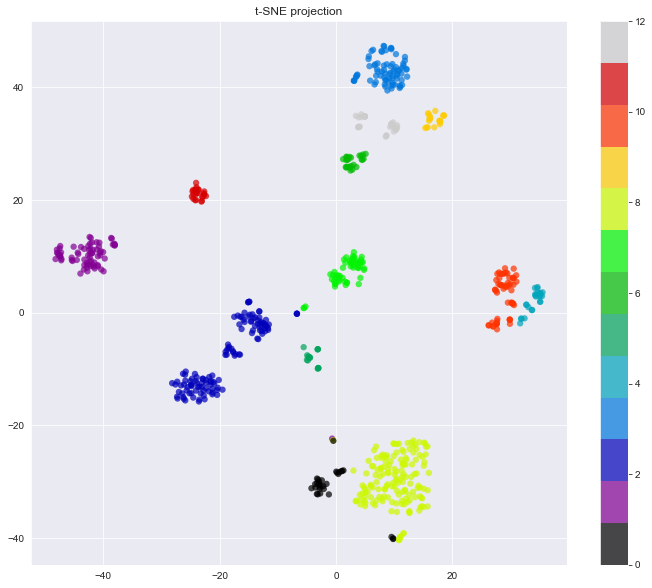

In [321]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', clusters))
plt.colorbar()
plt.title('t-SNE projection')

Projecting 29-dimensional data to 2D


Text(0.5, 1.0, 'PCA projection')

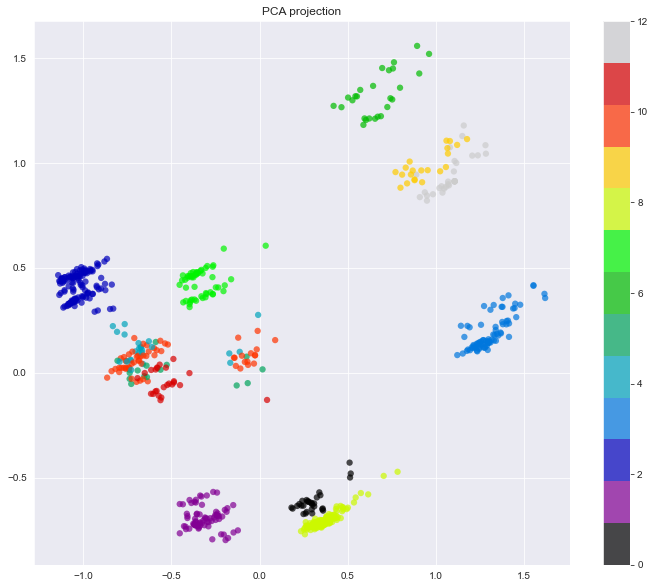

In [322]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', clusters))
plt.colorbar()
plt.title('PCA projection')

In [323]:
#UMAP

embedding = umap.UMAP().fit_transform(X)

Text(0.5, 1.0, 'UMAP')

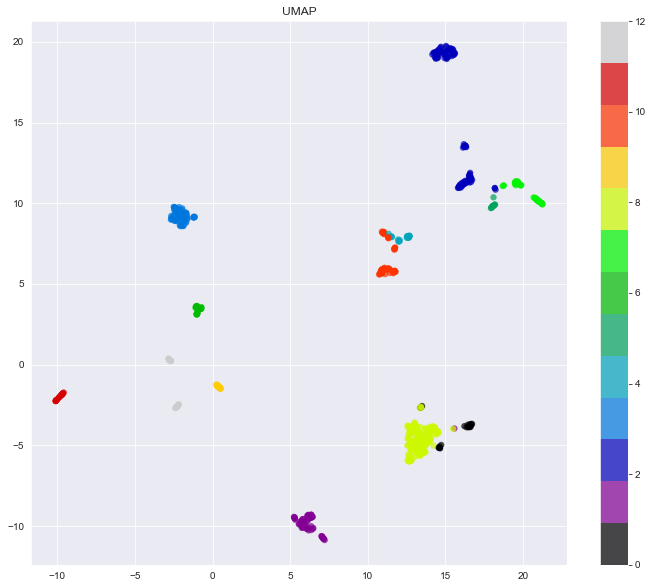

In [324]:
plt.figure(figsize=(12,10))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', clusters))
plt.colorbar()
plt.title('UMAP')

In [326]:
X.columns

Index(['price', 'parking_count', 'parking_min_distance', 'finance_count',
       'shop_count', 'distance_100', 'distance_500', 'cafe_count',
       'culture_count', 'job_gov_count', 'metro_count', 'metro_min_distance',
       'transport_count', 'transport_min_distance', 'working_days',
       'work_hours', 'weekday_availability', 'shop_centre', 'dns', 'is_center',
       'is_moscow', 'is_metro', 'is_transport', 'open_date',
       'place_type_other', 'place_type_КЦ', 'place_type_ОПС Б1',
       'place_type_ОПС Б1_2', 'place_type_ТП'],
      dtype='object')

## Выясним какие факторы важны для кластеризации

Feature ranking:
1. 28 0.158214 
2. 27 0.145769 
3. 21 0.123564 
4. 29 0.081558 
5. 1 0.080302 
6. 12 0.059433 
7. 22 0.056490 
8. 11 0.054556 
9. 15 0.039824 
10. 19 0.037523 


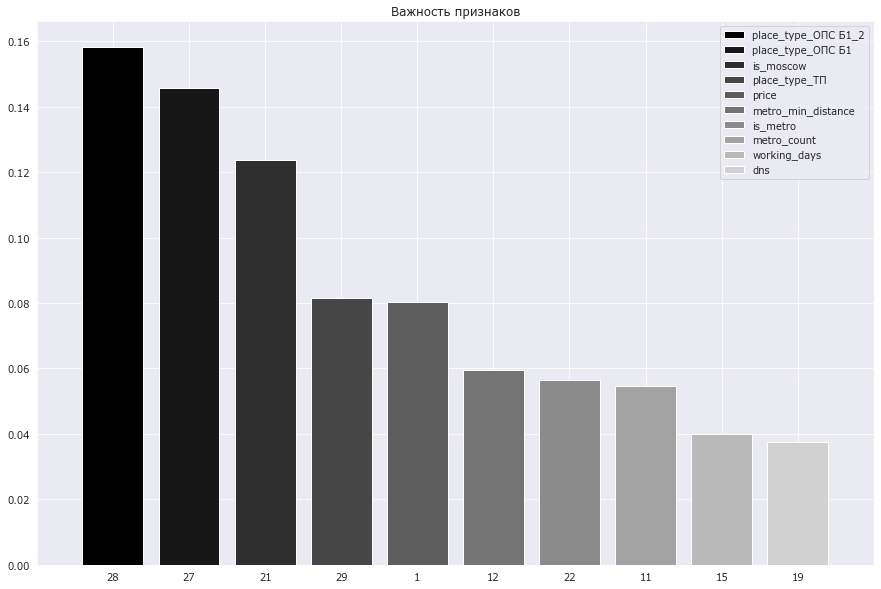

In [327]:
from __future__ import division, print_function

from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

n = 10

forest = RandomForestClassifier(n_estimators=1000, max_features=n,
                                random_state=0)

forest.fit(X,Y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = n
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            str(feature_indices[f]), 
            importances[indices[f]]))
plt.figure(figsize=(15,10))
plt.title(u"Важность признаков")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(str(X.iloc[:,i-1].name)) 
                  for i in feature_indices]);


По графику видно, что важнее всего: 
    
1. Тип отделения Б1_2 - два рабочих места сотрудников Банка и 
Б1 - 2 и более операционных окон в ОПС (в одно из которых размещаем сотрудника Банка). 

2. Затем в Москве или нет находится отделение.

3. place_type и ТП вносят одинаковый вклад.